In [1]:
import datetime

import BeeMotionTracker as MT
from importlib import reload
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import time

from scipy import signal
import pandas as pd
from matplotlib import pyplot as plt
from scipy import fftpack



DATA_PATH = '/Users/sean/Desktop/Bee Motion Tracker/beesearch-hand-annotated-data-main/'
PATH = '/Users/sean/Desktop/Bee Motion Tracker/'
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans



In [13]:
n = 19
print(f'Waggle dance {n}')
BMT = MT.BeeMotionTracker(f'{DATA_PATH}Video/RawFootage/WaggleDance_{n}.mp4',
                   f'{DATA_PATH}Locations/WaggleDance_{n}_Locations.csv', name= f'WaggleDance_{n}', Images =(0,100))
BMT.computeDMD()
print('fourier processed')


Waggle dance 19
image shape : (720, 1280)
fourier processed


In [14]:
def plotGraphs(imageIndex, ax, phi, BMT, s, strongestFreq,waggle_truth, pred_point, conv_point_pred):

    plt.title(f'index: {imageIndex} s: {s} strongestFreq: {strongestFreq} \n A: {np.sum(np.abs(phi))}')
    plt.imshow(phi.reshape(BMT.imageShape))
    ax.set(facecolor="white")
    plt.colorbar()
    if False:
        plt.title(f'index: {imageIndex}')
        plt.imshow(BMT.frames[imageIndex])
    loc = BMT.locationCors[imageIndex]
    x_true = int(loc[0])
    y_true = int(loc[1])
    if waggle_truth == 1:
        color = 'red'
    else:
        color = 'blue'
    plt.scatter(x_true, y_true, s=30, color = color)
    plt.scatter(pred_point[0],pred_point[1], s=30, color='orange')
    plt.scatter(conv_point_pred[0],conv_point_pred[1], s=30, color='yellow')
    plt.show()

In [15]:
def getCentriods(phi):
    largestPoints = MT.k_largest_index_argpartition_v2(np.abs(phi).reshape(BMT.imageShape), 1000)
    kmeans = KMeans(n_clusters=5,random_state=0).fit(largestPoints)

    clusters = [[] for i in range(5)]

    for i, l in enumerate(kmeans.labels_):
        clusters[l].append(largestPoints[i])
    cluster_size = [len(cluster) for cluster in clusters]
    #print(f'cluster : {cluster_size}')
    best_cluster = np.argmax(cluster_size) #MT.k_largest_index_argpartition_v2(np.array(cluster_size), 2)
    #print(f'bestclusers : {best_cluster}')
    centriodLocation1 = kmeans.cluster_centers_[best_cluster]
    return centriodLocation1.squeeze()

In [16]:

plot = False

def dmdPredict(BMT, plot=False, th = .13, kMethod = 'phi', comments = False, d = 50, runLabel ='testing'):
    fig, ax = plt.subplots()
    imageIndex = BMT.frameslength
    accuracies = []
    waggle_max = []
    waggle_max_conv = []
    walk_max = []
    walk_max_conv = []
    waggle_box = []
    walk_box = []
    b = 5
    dictitemsPhi = [('sumAbsPhi' + str(i), []) for i in range(b)]
    dictitemsVhs = [('vhs' + str(i), []) for i in range(b)]
    dictitemsbox_num = [('box_num' + str(i), []) for i in range(b)]
    areaStregth = [('areaStregth', [])]

    ## each pass through X is analysis for on image
    for phis, ss, vhs in zip(BMT.phis_all, BMT.ss_all, BMT.vhs_all):
        if comments:
            print()
            print(f"IMAGE : {imageIndex}")
            print()
        conv_max = 0
        waggle_truth = BMT.waggles[imageIndex]
        waggle_pred = 0
        box_num =  0


        ## get dyamic mode decomp
        st = time.time()
        ## for the modes, check the frequency
        mode = 0
        for phi, s, vh in zip(phis.T, ss, vhs):
            phi[np.abs(phi) < .003] = 0
            strengths = fftpack.fft(vh)
            freqs = fftpack.fftfreq(len(vh)) * BMT.fps
            strongestFreq = freqs[np.argmax(np.abs(strengths))]


            #hotSpot = MT.convolutionMax(np.abs(phi).reshape(BMT.imageShape), 10)
            #print(f'hotspot : {hotSpot}')
            if (np.abs(strongestFreq) <= 16 and np.abs(strongestFreq) >= 10) and np.sum(np.abs(phi)) > 50:
                if comments:
                    print('Candiate found')
                    print(f'abs : {np.sum(np.abs(phi))}')
                ### maybe take the top 1000 points and run k means to get the 5 clusters chose the best one, run larger convolutions in that area to detect bee or no bee
                ### maybe use image bluring t


                im = np.abs(phi).reshape(BMT.imageShape)

                row, col = np.unravel_index(im.argmax(), im.shape)

                k = 1
                kernal = np.ones((k,k))
                #circleMask = MT.createCircleMask((k,k), k/2)
                transform = signal.convolve2d(im, kernal, boundary='symm', mode='same') / k

                centLoc1 = getCentriods(phi)
                if comments: print(f'center location: {centLoc1}')

                cy = int(centLoc1[1])
                cx = int(centLoc1[0])
                box = im[cx-d: cx+d, cy-d:cy+d]
                if False:
                    cy2= int(centLoc2[1])
                    cx2 = int(centLoc2[0])
                    box2 = im[cx2-d: cx2+d, cy2-d:cy2+d]
                box_num = np.mean(box)
                #print(f'box : {box}')

                row_conv, col_conv = np.unravel_index(transform.argmax(), transform.shape)
                conv_max = max(conv_max, transform.flatten().max())
                if box_num > th:
                    waggle_pred = 1
                if plot: plotGraphs(imageIndex, ax, phi, BMT, s, strongestFreq,waggle_truth, (centLoc1[1], centLoc1[0]), (col_conv, row_conv))

                if waggle_truth == 1:
                    waggle_max_conv.append(conv_max)
                    waggle_max.append(np.abs(phi).max())
                    if box_num == box_num: waggle_box.append(box_num)
                else:
                    walk_max_conv.append(conv_max)
                    walk_max.append(np.abs(phi).max())
                    if box_num == box_num: walk_box.append(box_num)
                mode +=1
        ## print on false Negatives

        if plot:
            if waggle_pred == 1 and waggle_truth==0:
                for phi, s, vh in zip(phis.T, ss, vhs):
                    centriodLocation = getCentriods(phi)
                    strengths = fftpack.fft(vh)
                    freqs = fftpack.fftfreq(len(vh)) * BMT.fps
                    strongestFreq = freqs[np.argmax(np.abs(strengths))]
                    plotGraphs(imageIndex, ax, phi, BMT, s, strongestFreq, waggle_truth, (centLoc1[1], centLoc1[0]), (col_conv, row_conv))


        imageIndex +=1
        if comments:
            print()
            print(f'conv_max : {conv_max}')
            if conv_max != 0:
                print(f'box mean : {box_num}')

            print(time.time() - st)
            print(f'waggle Pred vs truth : {waggle_pred} vs {waggle_truth}')

        accuracies.append(waggle_truth-waggle_pred)

    plt.hist(waggle_max_conv, label= 'waggle_max_conv')
    plt.hist(walk_max_conv,  label= 'walk_max_conv')
    plt.show()
    plt.hist(waggle_max, label= 'waggle_max')
    plt.hist(walk_max,  label= 'walk_max')
    plt.show()
    plt.title('Mean around largest Kmeans cluster')
    plt.hist(waggle_box, label= 'Waggle mean around cluster')
    plt.hist(walk_box,  label= 'Walk mean around cluster')
    plt.legend()
    plt.show()
    for w in [  [waggle_max,'waggle_max'], [waggle_max_conv,'waggle_max_conv'], [waggle_box, 'waggle_box'],
                [walk_max, 'walk_max'], [walk_max_conv,'walk_max_conv'], [walk_box,'walk_box'] ]:
        print(f' {w[1]} std: {np.std(w[0])} mean: {np.mean(w[0])}')


    accuracies = np.array(accuracies)
    predLen = len(accuracies)
    correct = (accuracies == 0).sum()

    falsePos = (accuracies == -1).sum()
    falseNeg = (accuracies == 1).sum()
    waggleArray = np.array(BMT.waggles[BMT.frameslength:imageIndex])
    wagglePred = {"waggle_truth" : waggleArray.tolist(), "waggle_pred" :
        accuracies.tolist()}
    truePositives = np.sum(np.logical_and(accuracies == 0, waggleArray == 1))

    df = pd.DataFrame.from_dict(wagglePred)
    print(f'th = {th} d : {d} run label : {runLabel}')
    df.to_csv(f'{PATH}wagglePreds.csv', index=True)
    print(f'DMD accuracy : {round(correct/predLen,3)}')
    print(f'DMD precision:  {round(truePositives/(truePositives+falsePos),4)}')
    print(f'DMD recall : {round(truePositives/(truePositives+falseNeg),4)}')
    print(f'DMD FalsePos : {round(falsePos/predLen,4)}')
    print(f'DMD FalseNeg {round(falseNeg/predLen,4)}')
    print(f'waggle percentage: {np.mean(waggleArray)}' )

    return correct/predLen

image shape : (720, 1280)
fourier processed


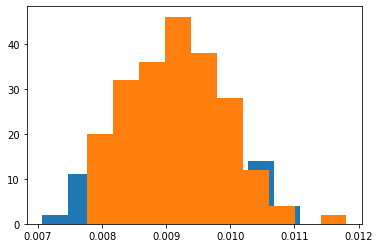

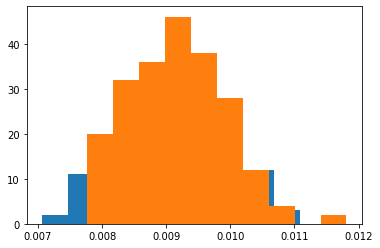

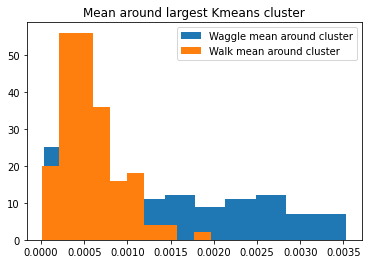

 waggle_max std: 0.0008526260621297099 mean: 0.008916004198149564
 waggle_max_conv std: 0.0008972831665304018 mean: 0.008976417423220818
 waggle_box std: 0.001031546664277462 mean: 0.001473900231904164
 walk_max std: 0.0007545046963873233 mean: 0.009198116570009615
 walk_max_conv std: 0.0007545046963873233 mean: 0.009198116570009615
 walk_box std: 0.0003398528735837071 mean: 0.0005787113601344973
th = 0.0024 d : 50 run label : testing
DMD accuracy : 0.66
DMD precision:  1.0
DMD recall : 0.1951
DMD FalsePos : 0.0
DMD FalseNeg 0.3402
image shape : (720, 1280)
fourier processed


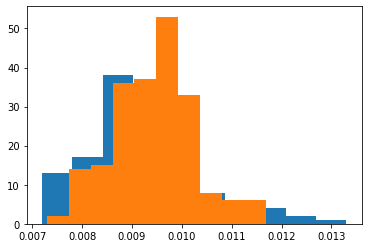

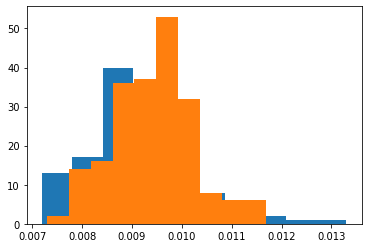

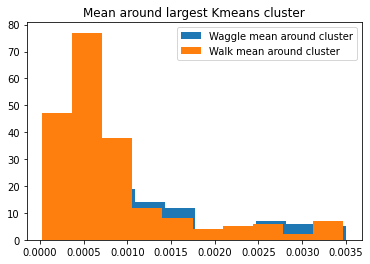

 waggle_max std: 0.001015398745991627 mean: 0.009145594881647187
 waggle_max_conv std: 0.0010926787620594632 mean: 0.009209848989928224
 waggle_box std: 0.0008980461332408692 mean: 0.001094404484870452
 walk_max std: 0.000831496580860973 mean: 0.009428453218846576
 walk_max_conv std: 0.0008295494995824761 mean: 0.009437153682452666
 walk_box std: 0.0007582627935624203 mean: 0.0008388543041549979
th = 0.0024 d : 50 run label : testing
DMD accuracy : 0.6
DMD precision:  0.619
DMD recall : 0.1566
DMD FalsePos : 0.041
DMD FalseNeg 0.359
image shape : (720, 1280)
fourier processed


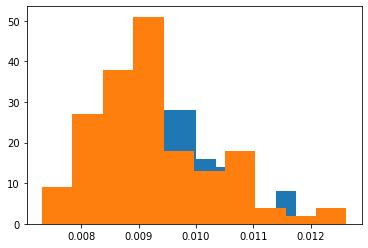

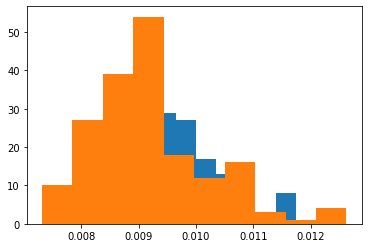

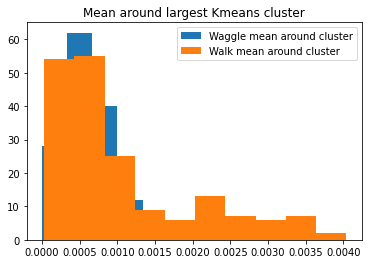

 waggle_max std: 0.0007445029604307563 mean: 0.00961413963614043
 waggle_max_conv std: 0.0007493403964339073 mean: 0.009632103978606154
 waggle_box std: 0.0005497278544073438 mean: 0.0007373316369608986
 walk_max std: 0.0010055014906890406 mean: 0.009196667684417584
 walk_max_conv std: 0.0010406941177126758 mean: 0.009252975283839724
 walk_box std: 0.000955346212489174 mean: 0.0010543531728680789
th = 0.0024 d : 50 run label : testing
DMD accuracy : 0.523
DMD precision:  0.1429
DMD recall : 0.0241
DMD FalsePos : 0.0615
DMD FalseNeg 0.4154
image shape : (720, 1280)
fourier processed


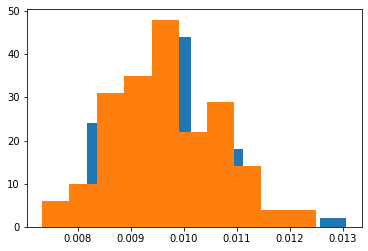

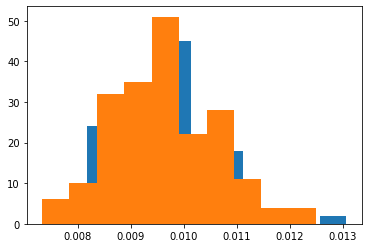

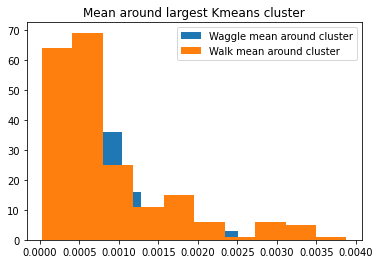

 waggle_max std: 0.0008726605629095248 mean: 0.009646546422741365
 waggle_max_conv std: 0.0008730927784267813 mean: 0.009652062155353539
 waggle_box std: 0.00046579345703392816 mean: 0.0007462523427702373
 walk_max std: 0.0010050389826325107 mean: 0.009644333917821192
 walk_max_conv std: 0.001023780869078387 mean: 0.009678551972250466
 walk_box std: 0.0007867157287063095 mean: 0.0008744216688302167
th = 0.0024 d : 50 run label : testing
DMD accuracy : 0.538
DMD precision:  0.1111
DMD recall : 0.012
DMD FalsePos : 0.041
DMD FalseNeg 0.4205
image shape : (720, 1280)


In [ ]:
# phi k means transform box
import warnings
chunks = 5
for i in range(chunks):
    with warnings.catch_warnings():
        BMT = MT.BeeMotionTracker(f'{DATA_PATH}Video/RawFootage/WaggleDance_{n}.mp4',
                           f'{DATA_PATH}Locations/WaggleDance_{n}_Locations.csv', name= f'WaggleDance_{n}', Images =(i*1000//chunks,(i+1)*1000//chunks))
        BMT.computeDMD()
        print('fourier processed')
        warnings.simplefilter("ignore", category=RuntimeWarning)
        dmdPredict(BMT=BMT, th=.0024, comments=False, d = 25)

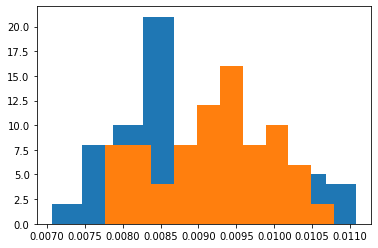

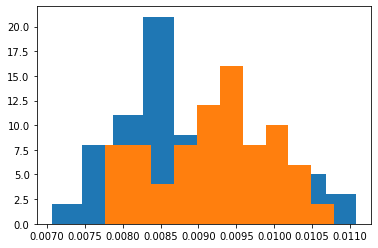

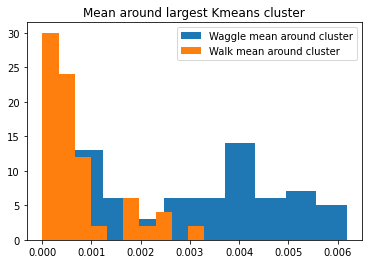

 waggle_max std: 0.000873165885379454 mean: 0.008838903286253445
 waggle_max_conv std: 0.0009168198546878121 mean: 0.008898728553932209
 waggle_box std: 0.0018877106280640757 mean: 0.0026802653423380405
 walk_max std: 0.0007696218796067361 mean: 0.00920051308451311
 walk_max_conv std: 0.0007696218796067361 mean: 0.00920051308451311
 walk_box std: 0.0007505089618547158 mean: 0.0007155755105246557
th = 0.0024 d : 25 run label : testing
DMD accuracy : 0.691
DMD precision:  0.9231
DMD recall : 0.4706
DMD FalsePos : 0.0213
DMD FalseNeg 0.2872


In [17]:
## results for transfrom kmeans transfrom box
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    dmdPredict(BMT=BMT, d= 25, th=.0024)

In [ ]:
a= np.array([1,2,2,2,3,4,6])
(a == 2).sum()

In [ ]:
## phi kmeans ## phi box
dmdPredict(BMT=BMT, th=.0024)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    dmdPredict(BMT=BMT, th=.001, comments=False)

In [ ]:
a ,b ,c ,d ,e, f = [np.arange(i) for i in range(6)]
print(a)
for w in [  (a,'waggle_max'), (b,'waggle_max_conv'), (c, 'waggle_box'),
            (d, 'walk_max'), (e,'walk_max_conv'), (f,'walk_box') ]:
    print(w[0])
    print(f' {w[1]} std: {np.std(w[0])} mean: {np.mean(w)}')